In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import nltk, string, random, numpy, os
import matplotlib.pyplot as plt
from typing import List
os.makedirs('./results', exist_ok=True)
nltk.download('brown')
random.seed(42)
torch.manual_seed(42)
numpy.random.seed(42)

/home/alex/anaconda3/envs/nlp_a4/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package brown to /home/alex/nltk_data...
[nltk_data]   Package brown is already up-to-date!


### Introduction
In the warm-up of this assignment, we will see how Neural Networks (NN) handle natural language data.   
The warm-up focuses on a simple Multilayer Perceptron (MLP), also known as a fully connected Neural Network. The data we'll use is the first 5000 unique words of the Brown corpus.

### Dataset
To train the model, we will have to represent the input words to the model in some way. Since models solely work with numbers, the words will have to be converted into numerical form.  
For this assignment, we will focus on predicting individual words from the dataset given the input of the model. The input will be the target word split up into individual letters. To represent these individual letters we will give the model a vector of 26 positions (26 letters in the English alphabet). Initially, this vector is filled with zeros and for every occuring letter in the word we change the value to 1 in that position. For instance, in the word `apple', we have 1 a, 1 e, 1 l and 2 p. The vector will then represent the word as:  
```[1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0]```  
You will have to implement this algorithm together with loading the Brown dataset and taking the first 5000 unique words. Implement a way to store the indexes of the unique words as a dictionary where the word is the key and the index is the value as well as the target list (which will be just the indexes of the words).

In [6]:
class AlphaDataset(Dataset):
    def __init__(self) -> None:
        # Load the NLTK Brown corpus and store the first 5000 unique words of the corpus in self.data
        data = nltk.corpus.brown.words()
        data = list(set(data))
        self.data = data[:5000]
        # Convert the unique words to an index dictionary {word: index}
        self.word_to_idx =  {word: idx for idx, word in enumerate(self.data)}
        # Make these indexes the target values
        self.targets = [self.word_to_idx[word] for word in self.data]

    def __len__(self) -> int:
        # Torch requires the implementation of the length function to calculate the number of instances in the dataset. Find a way to implement this
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        embedding = [0] * 26
        for char in x.lower():
            if char in string.ascii_lowercase:
                embedding[ord(char) - ord('a')] += 1

        # Apply processing to turn the word (stored in x) into a numeric vector of 26 numbers, counting the occurences of the letters.
        # Example: apple would become [1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0], counting 2 occurences for the letter p and zero for letters that do not occur.

        x = torch.tensor(embedding, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y
    

### Multilayer Perceptron
In the following section, you will implement a MLP. The goal is to implement this MLP with 1 input layer, 2 hidden layers, and 1 output layer.
With PyTorch, the linear layer is most suitable for this. When you create a linear layer, you define the input and output size of the layer, effectively creating two linear neuron layers. This is useful to know since we only need to create 3 linear layer classes to have the 4 layers we want.
The hidden size is stored as a list where the first value will be 256 and the second value will be 512.

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: List[int], output_size: int) -> None:
        super().__init__()
        # Implement the neural network layers, the activation function is already defined
        self.input_layer = torch.nn.Linear(input_size, hidden_size[0])
        self.hidden_layer = torch.nn.Linear(hidden_size[0], hidden_size[1])
        self.output_layer = torch.nn.Linear(hidden_size[1], output_size)

        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # In the forward pass the model will calculate the gradients as well as the probabilities of the result occuring given its input.
        # Implement the missing layers

        x = self.input_layer(x)
        x = self.activation(x)
        x = self.hidden_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)

        return x

### Setting up the hyperparameters
These are the hyperparameters used for the model, they define the layout of the model as well as the performance:
- batch_size, defines the number of instances the model sees at one time.
- learning_rate, defines the change rate of the gradient descent.
- input_size, the number of input neurons for the model, the number of letters in the alphabet
- hidden_size, the number of neurons in the hidden layer
- output_size, the number of neurons in the output layer, for us this is the number of unqiue words

In [9]:
batch_size = 8
learning_rate = 1e-5
input_size = 26
hidden_size = [256, 512]
output_size = 5000
device = 'cpu' # If you have an m1 macbook use: 'mbp', if you have an NVIDIA GPU use: 'cuda:0' else leave as is

Setting up the dataset

In [10]:
# Define the dataset and the dataloader
dataset = AlphaDataset()

# For the final evaluation of the model we will use 20% of the data for testing. Testing is only ever done after hyperparameter tuning.
# Split sizes (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# To evaluate our model we want to take 10% of the dataset for validation, this is similar to the testset, rather this data we can use during hyperparameter tuning.
# The validation and test data is never trained on and is unseen data for the model, making it closer to a production setting.
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffling ensures the model does not overfit on ordering of the data.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # This data does not need to be shuffled
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  #T his data does not need to be shuffled

### Preperation for training
Here we load the model into memory, apply it to the selected device and define the optimizer. The optimizer guides the model to the best possible state it can be in through Gradient descent.
Lastly, the loss function is defined, this defines how well the model performs, based on this number the model knows how it should change its weights.

In [11]:
model = MLP(input_size, hidden_size, output_size)
model.to(device) # Tell de model which accelerator to use (Macbook GPU, NVIDIA GPU or CPU)

# In Neural Networks optimizers handle the efficient training through gradient descent, we will use Adam
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# The loss function defines how well the model is performing, if the loss is low the model is rewarded, if it is high the model is punished.
# Since we are dealing with a classification task we will use Cross Entropy
loss_fn = nn.CrossEntropyLoss()

### Training
In the next block the training block is already defined. This is a standard way to train the model for 50 epochs (50 times it will see the dataset). Each time it does one epoch we also go over the validationset.

In [12]:
training_losses = []
validation_losses = []

for epoch in range(50): # Train for 50 epochs
    model.train() # Enforce model training
    for step, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        training_losses.append(loss.item())
        print(loss.item(), end='\r')

        loss.backward() # Calculate gradients

        optimizer.step() # Reward the model
        optimizer.zero_grad() # Clean the gradients
    print('Training_loss:', loss.item())

    model.eval() # After every training epoch we want to see the model's performance on the validation data
    with torch.no_grad(): # In validation we dont need gradients so we tell torch to not calculate them
        total_val_loss = 0
        for step, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)

            output = model(x)

            loss = loss_fn(output, y)

            total_val_loss += loss.item()

        validation_losses.append(total_val_loss / len(val_dataset))
        print('Validation_loss:', validation_losses[-1])

Training_loss: 8.582656860351562
Validation_loss: 1.0694255542755127
Training_loss: 8.455168724060059
Validation_loss: 1.0808128428459167
Training_loss: 8.313003540039062
Validation_loss: 1.0994712591171265
Training_loss: 8.26032829284668
Validation_loss: 1.1305479073524476
Training_loss: 8.065718650817871
Validation_loss: 1.175677695274353
Training_loss: 7.796915531158447
Validation_loss: 1.2306990003585816
Training_loss: 7.87078857421875
Validation_loss: 1.2904150676727295
Training_loss: 7.628386497497559
Validation_loss: 1.3509221124649047
Training_loss: 7.289324760437012
Validation_loss: 1.4114833188056946
Training_loss: 7.485624313354492
Validation_loss: 1.4721637177467346
Training_loss: 7.368491172790527
Validation_loss: 1.5340542387962341
Training_loss: 7.421064853668213
Validation_loss: 1.5977390956878663
Training_loss: 7.2226057052612305
Validation_loss: 1.6636906242370606
Training_loss: 6.917443752288818
Validation_loss: 1.7328591966629028
Training_loss: 6.742266654968262
Val

### Writing
Below we can print the training statistics, the training loss should be going down while the validation loss should be going up. What does it mean that the validation loss increases?

That means we are overfitting to the training set


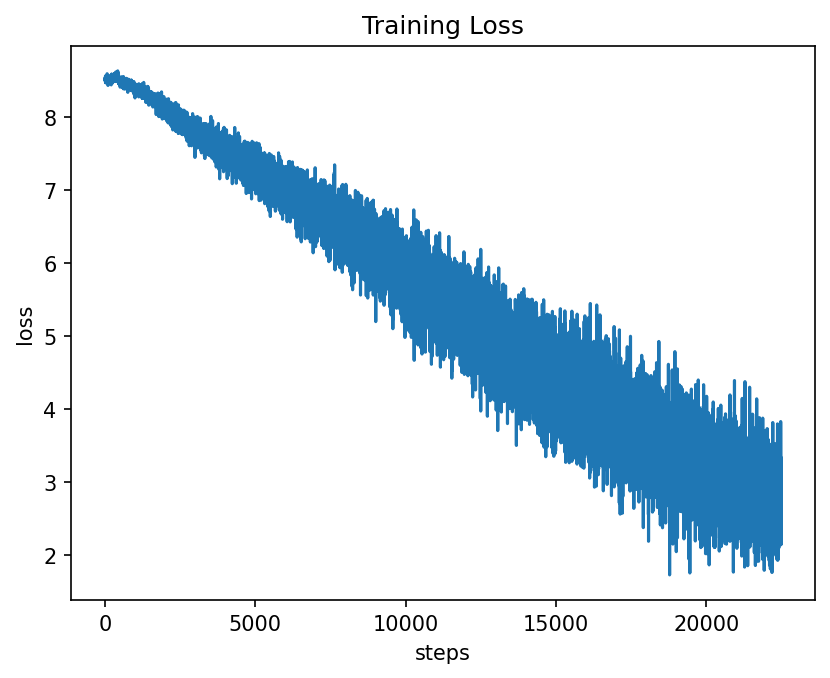

In [13]:
plt.rcParams['figure.dpi'] = 150
plt.plot(training_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Training Loss')
plt.savefig('./results/training_loss.png')

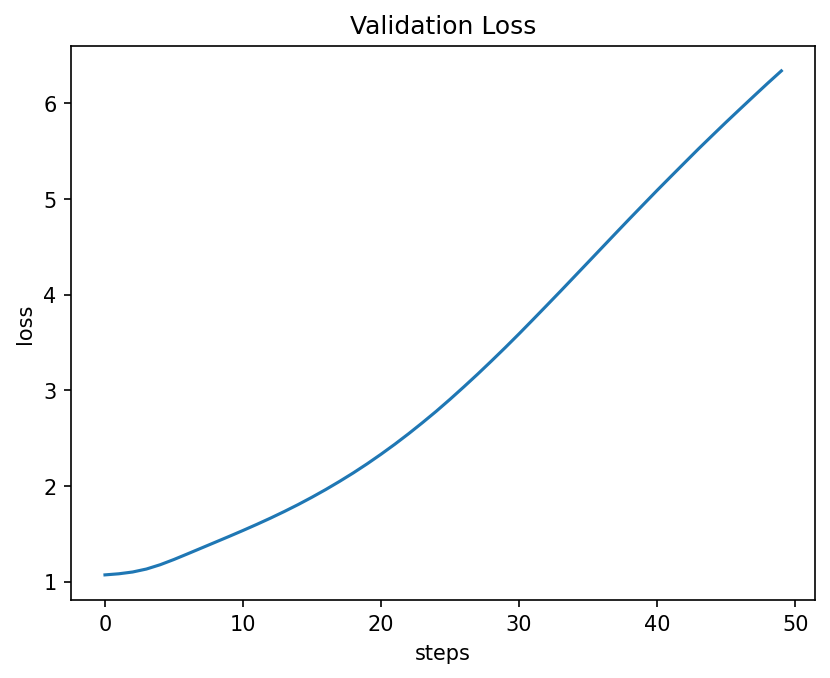

In [14]:
plt.plot(validation_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Validation Loss')
plt.savefig('./results/validation_loss.png')

### Writing
Belowe we want to analyze how the model functions based on the test data. What stands out from these results? Was the result correct? What is the main difference between the words?

None of the predicted words is correct. This is expected as the model has never even seen the indeces of the test set. The general letter composition is similar though.

In [ ]:
def get_n_words(dataset, n, model, ds, verbose = True):
    if n == -1:
        n = len(dataset)
    x = [dataset.__getitem__(i)[0] for i in range(n)]
    y = [dataset.__getitem__(i)[1] for i in range(n)]
    target_words = [{idx: word for word, idx in ds.word_to_idx.items()}[_.item()] for _ in y]
    out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]
    predicted_words = [{idx: word for word, idx in ds.word_to_idx.items()}[_.item()] for _ in out]
    width = max(len(word) for word in target_words) + 5
    if verbose:
        print('\n'.join([f'target: {t.ljust(width)} predicted: {p}' for t, p in zip(target_words, predicted_words)]))
    return target_words, predicted_words

_,_ = get_n_words(test_dataset, 10, model, dataset)

target: Kissing           predicted: insisting
target: full-fledged      predicted: fuller
target: requires          predicted: reimburse
target: protection        predicted: projection
target: Lorrain           predicted: ironical
target: Gradually         predicted: gradual
target: cracking          predicted: anarchic
target: Telephones        predicted: Nonetheless
target: endeavoring       predicted: fine-grained
target: stylish           predicted: skylight


/home/alex/anaconda3/envs/nlp_a4/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


Why are some words incorrectly predicted?

see above, the model doesnt know the indeces of the test set

### Code + Written
Research the Jaccard similarity metric for calculating the difference between the predicted word and the target word. Reference your sources and implement this metric in your code below. You can use the get_n_words function with n=-1 to get all the predicted and target words. Compare this method to similarity as measured with one of the word vector methods from A2, in writing and/or code.

[Your answer here]

In [ ]:
# compare with jaccard similarity
# from https://mayurdhvajsinhjadeja.medium.com/jaccard-similarity-34e2c15fb524
target_words,predicted_words = get_n_words(test_dataset, -1, model, dataset,verbose=False)
def jaccard_similarity(w1, w2):
    set1 = set(w1)
    set2 = set(w2)
    return len(set1.intersection(set2)) / len(set1.union(set2))
similarities = [jaccard_similarity(t, p) for t, p in zip(target_words, predicted_words)]
print(f'Jaccard similarity: {sum(similarities) / len(similarities)}')

/home/alex/anaconda3/envs/nlp_a4/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


Jaccard similarity: 0.57845012397733


In [ ]:
# Method 2